# Import Packages

In [1]:
# load those needed packages and libraries
import torch
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction
from transformers import T5Tokenizer, T5ForConditionalGeneration

# set the device to cuda if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the dataset
text_df = pd.read_csv("Grammar_Correction.csv")

c:\Users\Bryan Chan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preview Data
data collected from: https://www.kaggle.com/code/satishgunjal/mining-mastering-the-art-of-english-corrections

In [4]:
text_df

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.
...,...,...,...,...
2013,2014,Lack of Parallelism in Lists or Series,"The festival celebrates music, culture, and to...","The festival celebrates music, culture, and br..."
2014,2015,Lack of Parallelism in Lists or Series,The seminar will address topics such as career...,The seminar will address topics such as career...
2015,2016,Lack of Parallelism in Lists or Series,The research examines the effects of climate c...,The research examines the effects of climate c...
2016,2017,Lack of Parallelism in Lists or Series,"The report highlights the need for investment,...","The report highlights the need for investment,..."


In [2]:
# display the first 10 rows of the dataset to understand the data structure and format of the dataset
text_df.head(10)

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.
5,6,Verb Tense Errors,I am eat pizza for lunch.,I am eating pizza for lunch.
6,7,Verb Tense Errors,The students studies for the exam.,The students study for the exam.
7,8,Verb Tense Errors,The car need to be repaired.,The car needs to be repaired.
8,9,Verb Tense Errors,She will goes to the party tonight.,She will go to the party tonight.
9,10,Verb Tense Errors,They watches the movie together.,They watch the movie together.


Text(0, 0.5, 'Error Type')

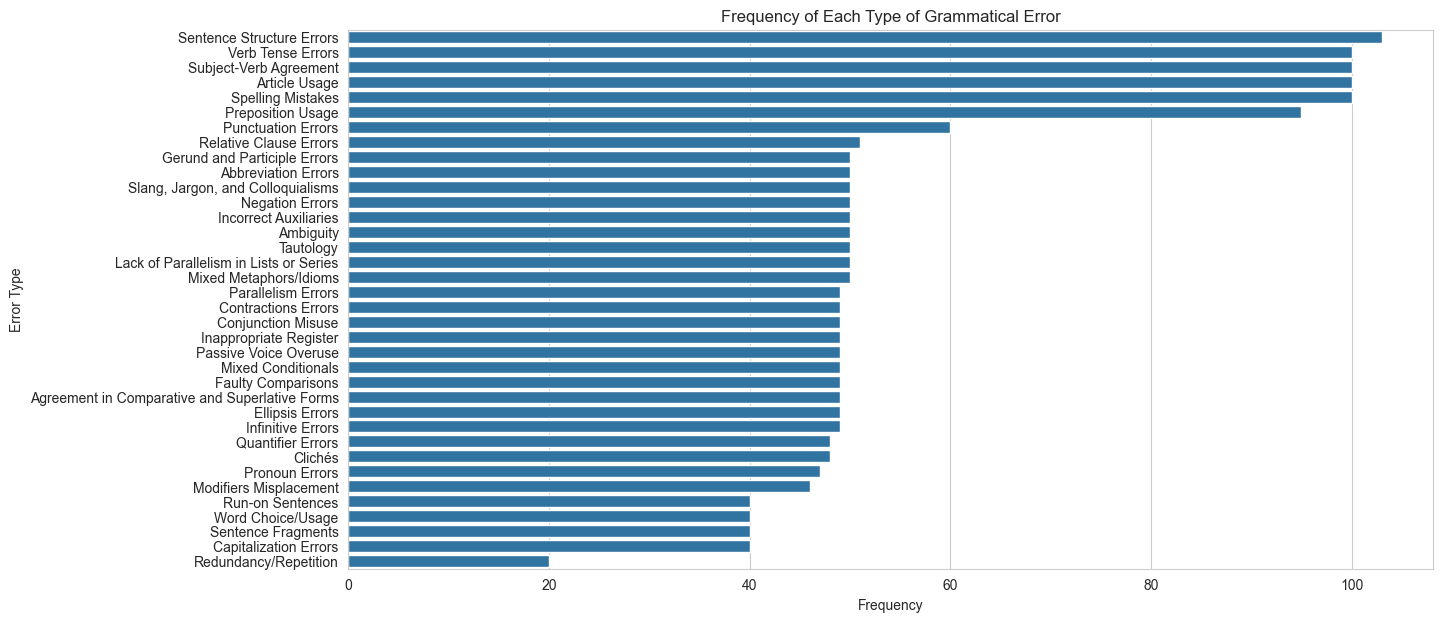

In [3]:
# display the shape of the dataset to understand the number of rows and columns in the dataset
sns.set_style("whitegrid") # SNS crease statistical graphics in Python
plt.figure(figsize = (14, 7))

# creates a count plot
error_type_plot = sns.countplot(y = text_df["Error Type"],                             # use the "Error Type" column
                                order = text_df["Error Type"].value_counts().index)    # sorts the Count frequencies

# add Plot labels
error_type_plot.set_title("Frequency of Each Type of Grammatical Error")
error_type_plot.set_xlabel("Frequency")
error_type_plot.set_ylabel("Error Type")

In [5]:
text_df

,Serial Number,Error Type,Ungrammatical Statement,Standard English,Ungrammatical Length,Standard Length
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.,29,27
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.,35,36
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.,32,31
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.,25,27
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.,25,26
...,...,...,...,...,...,...
2013,2014,Lack of Parallelism in Lists or Series,"The festival celebrates music, culture, and to...","The festival celebrates music, culture, and br...",69,67
2014,2015,Lack of Parallelism in Lists or Series,The seminar will address topics such as career...,The seminar will address topics such as career...,101,101
2015,2016,Lack of Parallelism in Lists or Series,The research examines the effects of climate c...,The research examines the effects of climate c...,107,105
2016,2017,Lack of Parallelism in Lists or Series,"The report highlights the need for investment,...","The report highlights the need for investment,...",95,93


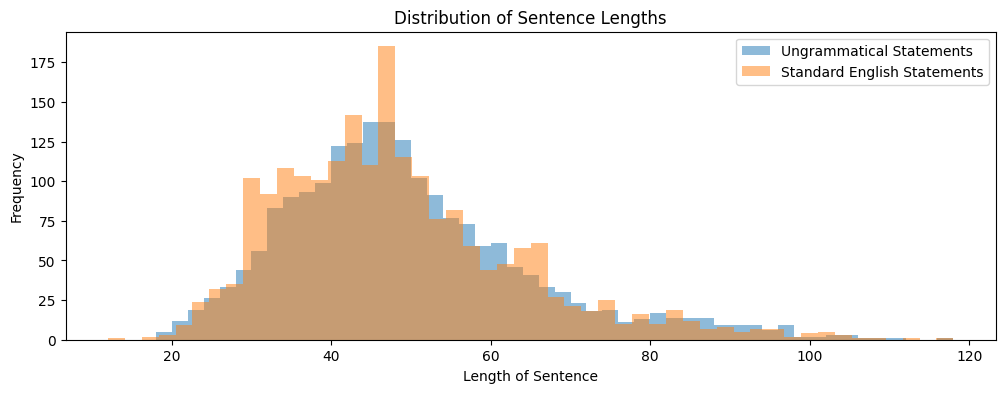

In [4]:
# add the length of the ungrammatical and standard English statements to the dataset
text_df["Ungrammatical Length"] = text_df["Ungrammatical Statement"].apply(len) # calculates the length of each string
text_df["Standard Length"] = text_df["Standard English"].apply(len) 

# display the distribution of sentence lengths for the ungrammatical and standard English statements
plt.figure(figsize = (12, 4))
plt.hist(text_df["Ungrammatical Length"], 
         bins = 50, 
         alpha = 0.5, 
         label = "Ungrammatical Statements")
plt.hist(text_df["Standard Length"], 
         bins = 50, 
         alpha = 0.5, 
         label = "Standard English Statements")

plt.title("Distribution of Sentence Lengths")
plt.xlabel("Length of Sentence")
plt.ylabel("Frequency")
plt.legend()
plt.show() 

In [7]:
# define the GrammarCorrectionDataset class for the dataset
class GrammarCorrectionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    # return the ungrammatical statement and the standard English statement
    def __getitem__(self, idx):
        ungrammatical_statement = self.dataframe.iloc[idx]["Ungrammatical Statement"]
        standard_english = self.dataframe.iloc[idx]["Standard English"]
        return ungrammatical_statement, standard_english

In [8]:
# split the dataset into training, validation, and test sets with 80%, 10%, and 10%
train_df, test_df = train_test_split(text_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.1)

# create the GrammarCorrectionDataset for the training, validation, and test sets
train_dataset = GrammarCorrectionDataset(train_df)
val_dataset = GrammarCorrectionDataset(val_df)
test_dataset = GrammarCorrectionDataset(test_df)


# Load H.F. Model

In [9]:
# load the pre-trained T5 model and tokenizer from the Hugging Face Transformers library 
# set the shared parameters (as freezing those parameters defined during the pre-trained stage to avoid catastrophic forgetting) to False
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# set the shared parameters to False
# This freezes the parameters to prevent them from being updated during training
for param in model.shared.parameters():
    param.requires_grad = False

c:\Users\Bryan Chan\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Bryan Chan\.cache\huggingface\hub\models--t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization

# Split Data

**Why do we create a Custom Datasets after splitting?**

Since you're using the Transformers library, creating a custom dataset using *GrammarCorrectionDataset* likely streamlines the training process by providing a data structure compatible with the library's expectations

In [38]:
# split the dataset into training, validation, and test sets with 80%, 10%, and 10%
train_df, test_df = train_test_split(text_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.1)

# create the GrammarCorrectionDataset for the training, validation, and test sets
train_dataset = GrammarCorrectionDataset(train_df)
val_dataset = GrammarCorrectionDataset(val_df)
test_dataset = GrammarCorrectionDataset(test_df)


train_df

,Serial Number,Error Type,Ungrammatical Statement,Standard English
1925,1926,Gerund and Participle Errors,He was annoy by the constant noise.,He was annoyed by the constant noise.
1740,1741,Abbreviation Errors,The CPU and GPU of the sys are quite powerful.,The central processing unit and graphics proce...
504,505,Spelling Mistakes,7. She prefered to eat apple instead of orange.,7. She preferred to eat an apple instead of an...
126,127,Subject-Verb Agreement,The faculty in the department is diverse and e...,The faculty in the department are diverse and ...
469,470,Sentence Structure Errors,The books on the shelf are belongs to the libr...,The books on the shelf belong to the library.
...,...,...,...,...
1825,1826,Relative Clause Errors,She's the teacher teaches math at our school.,She's the teacher who teaches math at our school.
63,64,Verb Tense Errors,The waiter serve the food to the customers.,The waiter served the food to the customers.
546,547,Spelling Mistakes,49. The sun is shining bright and it's a beuti...,"49. The sun is shining bright, and it's a beau..."
869,870,Mixed Metaphors/Idioms,"32. There's no smoke without fire, but you can...",32. There's no smoke without fire.


# Moving Model to Device

This code snippet prepares your environment and sets up the essential components for training a grammar correction model using the Transformers library

In [11]:
# create the DataLoaders for the training, validation, and test sets
model = model.to(device)

# set the model to training mode
optimizer = torch.optim.Adam(model.parameters(),      # Retrieves all the trainable parameters of the pre-trained T5 model
                             lr = 1e-4)               # Sets the learning rate = 0.0001

# initialize the Scheduler: scheduler is used to adjust the learning rate during training - avoid overfitting
scheduler = StepLR(optimizer, 
                   step_size = 1,                     # decays by 'every epoch'
                   gamma = 0.1)                       # decays the learning rate by a factor of 0.1

# Define Functions:

## train_epoch
this function iterates through batches of training data, prepares them for the model, performs a forward pass to get predictions, calculates the loss, updates the model's parameters using backpropagation and optimization, and finally returns the average loss

In [12]:
# define the train_epoch function to train the model for one epoch
def train_epoch(model, dataloader, optimizer, device, scheduler):
    
    # set the model to the device
    model = model.to(device)
    
    # set the model to training mode
    model.train()
    
    # initialize the total loss to 0
    total_loss = 0
    
    # iterate over the dataloader to get the ungrammatical statement and the standard English statement
    for ungrammatical_statement, standard_english in dataloader:
        # move the inputs and labels to the device, set the configuration for the tokenizer, and get the outputs from the model
        inputs = tokenizer(ungrammatical_statement, 
                           return_tensors = "pt", 
                           padding = True, truncation=True, 
                           max_length = 256).to(device)
        labels = tokenizer(standard_english, 
                           return_tensors = "pt", 
                           padding = True, truncation = True, 
                           max_length = 256).input_ids.to(device)
        
        outputs = model(**inputs, labels = labels)

        # get the loss from the outputs and add it to the total loss
        loss = outputs.loss
        total_loss += loss.item()
        
        # backpropagate the loss and update the optimizer
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # update the scheduler
    scheduler.step()
    
    # calculate the average loss
    average_loss = total_loss / len(dataloader)
    return average_loss

## eval_model

Defines a function that evaluates the performance of the grammar correction model on a given dataset

In [13]:
# define the eval_model function to evaluate the model on the validation or test set
def eval_model(model, dataloader, device):

    # set the model to the device
    model = model.to(device)

    # set the model to evaluation mode
    model.eval()

    # initialize the total BLEU score to 0
    total_bleu_score = 0

    # set the smoothing function to method1
    smoothing = SmoothingFunction().method1

    with torch.no_grad():

        # iterate over the dataloader to get the ungrammatical statement and the standard English statement
        for ungrammatical_statement, standard_english in dataloader:

            # move the inputs and labels to the device, set the configuration for the tokenizer, and get the outputs from the model
            inputs = tokenizer(ungrammatical_statement, 
                               return_tensors = "pt", 
                               padding = True, truncation = True, 
                               max_length = 256).to(device)
            labels = tokenizer(standard_english, return_tensors = "pt", 
                               padding = True, truncation = True, 
                               max_length = 256).input_ids.to(device)
            
            outputs = model.generate(**inputs, max_new_tokens = 256)

            # decode the outputs and calculate the BLEU score
            corrected_english = tokenizer.decode(outputs[0], 
                                                 skip_special_tokens = True) # decodes the generated sequence of tokens into human-readable text
            
            reference = [standard_english[0].split()]
            candidate = corrected_english.split()

            bleu_score = sentence_bleu(reference, 
                                       candidate, 
                                       smoothing_function = smoothing)
            
            total_bleu_score += bleu_score

    average_bleu_score = total_bleu_score / len(dataloader)

    print(average_bleu_score)
    return average_bleu_score

In [19]:
len?

Signature: len(obj, /)
Docstring: Return the number of items in a container.
Type:      builtin_function_or_method

# Tune Hyperparameters

This step uses Optuna to explore different learning rates, training epochs, and batch sizes to find the combination that optimizes the BLEU score (grammar correction accuracy) on the validation set

In [ ]:
# using optuna to tune the 
#   hyperparameters of the model and 
#   optimizer to improve the BLEU score on the validation set with 10 trials

def objective(trial): # takes a 'trial' object from Optuna as input

    # define the hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)              # between 1e-6 and 1e-4 on a logarithmic scale
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)                          # Number of Epochs to train the model - between 1 and 5
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])                    # Batch Size determines how many examples are processed together
    
    # load the pre-trained T5 model and tokenizer from the Hugging Face Transformers library
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    model = T5ForConditionalGeneration.from_pretrained("t5-base")

    # set the shared parameters to False
    for param in model.shared.parameters():
        param.requires_grad = False
    
    # set the optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = learning_rate)
    scheduler = StepLR(optimizer, 
                       step_size = 1, 
                       gamma = 0.1)

    # create the DataLoaders for the training and validation
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

    # train the model for the specified number of epochs
    for epoch in range(num_train_epochs):
        # train the model for one epoch and print the average loss
        average_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
        print(f"Epoch: {epoch+1}, Loss: {average_loss}")
        eval_model(model, val_dataloader, device)

    # evaluate the model with the validation set and return the average BLEU score
    average_bleu_score = eval_model(model, 
                                    test_dataloader, 
                                    device)
    return average_bleu_score

# create a study and optimize the objective function with 5 trials
study = optuna.create_study(direction = "maximize", 
                            pruner = optuna.pruners.MedianPruner())
study.optimize(objective, n_trials = 5)

# print the best hyperparameters
print(study.best_params)

In [12]:
# load the pre-trained T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# set the shared parameters to False
for param in model.shared.parameters():
    param.requires_grad = False
    
# set the device to cuda if available else cpu
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Get Best Hyperparameters

In [14]:
# get the best hyperparameters from the study
learning_rate = study.best_params["learning_rate"]

num_train_epochs = study.best_params["num_train_epochs"]

per_device_train_batch_size = study.best_params["batch_size"]

Epoch: 1, Loss: 1.8484593085620715
0.6237771250424272
0.6546422658052603


0.6546422658052603

## Fit Model with Best Hyperparameters

In [ ]:
# set the optimizer and scheduler with the best hyperparameters
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = learning_rate)
scheduler = StepLR(optimizer, 
                   step_size = 1, 
                   gamma = 0.1)

# create the DataLoaders for the training, validation, and test sets with the best hyperparameters (the batch size)
train_dataloader = DataLoader(train_dataset, 
                              batch_size = per_device_train_batch_size, 
                              shuffle = True) # ensure the data is shuffled within each dataset
val_dataloader = DataLoader(val_dataset, 
                            batch_size = per_device_train_batch_size, 
                            shuffle = True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size = per_device_train_batch_size, 
                             shuffle = True)

# train the model for the specified number of epochs with the best hyperparameters and evaluate the model on the validation and test sets
for epoch in range(num_train_epochs):
    average_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)

    print(f"Epoch: {epoch+1}, 
          Loss: {average_loss}")
    
    eval_model(model, val_dataloader, device)

# evaluate the model on the test set with the best hyperparameters and print the average BLEU score
eval_model(model, test_dataloader, device)

# Implement Tuned model

In [15]:
# implement the fine-tuned model on the dataset to correct the ungrammatical statements
def correct_grammar(model, ungrammatical_statement):

    # set the model to evaluation
    model.eval()

    # tokenize the ungrammatical statement and get the outputs from the model
    inputs = tokenizer(ungrammatical_statement, 
                       return_tensors = "pt", 
                       padding = True, truncation = True, 
                       max_length = 256).to(device)
    
    outputs = model.generate(**inputs, 
                             max_new_tokens = 256)

    # decode the outputs and return the corrected English statement
    corrected_english = tokenizer.decode(outputs[0], 
                                         skip_special_tokens = True)
    return corrected_english

# correct the ungrammatical statements in the dataset
text_df["Corrected English"] = text_df["Ungrammatical Statement"].apply(lambda x: correct_grammar(model, x))

In [16]:
text_df.head(10)

,Serial Number,Error Type,Ungrammatical Statement,Standard English,Corrected English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.,He don't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.,The sun rise in the east.
5,6,Verb Tense Errors,I am eat pizza for lunch.,I am eating pizza for lunch.,I am eat pizza for lunch.
6,7,Verb Tense Errors,The students studies for the exam.,The students study for the exam.,The students study for the exam.
7,8,Verb Tense Errors,The car need to be repaired.,The car needs to be repaired.,The car needs to be repaired.
8,9,Verb Tense Errors,She will goes to the party tonight.,She will go to the party tonight.,She will go to the party tonight.
9,10,Verb Tense Errors,They watches the movie together.,They watch the movie together.,They watch the movie together.
